In [1]:
using Revise
using CUDA

# Application analysis and optimization

Accurately measuring execution time of GPU operations and its kernels is obviously important in order to optimize your application, but is complicated by the fact that GPU operations often run asynchronously, and on a different device (so Julia's existing tools generally don't work). In this notebook, I'll explain the different alternatives, and how to best use them.

## Time measurements

In Julia, we're used to using `@time`, `@elapsed`, and BenchmarkTools.jl for measuring the time it takes to execute some code. These tools can be used with code that performs GPU operations, but there's a caveat:

In [2]:
A = CUDA.rand(Float32, 1024, 1024);
B = CUDA.rand(Float32, 1024, 1024);

# warmup
A * B

# measure time
@time A * B;

  0.000070 seconds (32 allocations: 624 bytes)


The main problem with this measurement is that GPU operations are asynchronous, so we're really measuring the time to *submit* this operation, not the time it takes to complete it. To accurately measure execution time, we need to synchronize:

In [3]:
# make sure the GPU is idle _before_ starting the measurement
synchronize()

@time begin
    A * B
    synchronize()
end

  0.033050 seconds (77.19 k allocations: 4.149 MiB, 98.90% compilation time)


This is exactly what CUDA.jl's version of the `@time` macro does. In addition, it reports on GPU allocations; `Base.@time` only reports CPU allocations:

In [4]:
CUDA.@time A * B;

  0.001398 seconds (47 CPU allocations: 1.375 KiB) (1 GPU allocation: 4.000 MiB, 0.78% memmgmt time)


If you need to access these timings programmatically, you can use CUDA.jl's version of the `@timed` macro:

In [5]:
CUDA.@timed A * B

(value = Float32[255.13716 258.35574 … 268.787 264.22656; 267.99973 272.66614 … 274.87433 274.34445; … ; 250.27515 254.57367 … 262.51657 259.36014; 254.1278 257.36093 … 261.0692 260.70612], time = 0.000495133, cpu_bytes = 1408, cpu_gctime = 0.0, cpu_gcstats = Base.GC_Diff(1408, 0, 0, 47, 0, 0, 0, 0, 0), gpu_bytes = 4194304, gpu_memtime = 9.659999999994673e-6, gpu_memstats = CUDA.AllocStats(1, 4194304, 0, 0, 9.659999999994673e-6))

For even simpler measurements, you can use `CUDA.@elapsed` behaving like `Base.@elapsed`. One minor difference to the other macros, is that it uses events to measure time and does not synchronize the entire stream, so it is a better mechanism when your application needs timings without disturbing the execution:

In [6]:
CUDA.@elapsed A * B

0.00039916803f0

## Benchmarks

Most of the time, you shouldn't bother with these simple measurements and move on to BenchmarkTools.jl. The same rules apply -- make sure you synchronize the GPU so that actual execution time is measured -- but because BenchmarkTools.jl performs multiple iterations it's sufficient to synchronize at the end. The `CUDA.@sync` macro is very useful for that:

In [7]:
using BenchmarkTools
b = @benchmark CUDA.@sync A * B

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  261.506 μs … 271.158 ms  ┊ GC (min … max): 0.00% … 0.95%
 Time  (median):     288.875 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   408.683 μs ±   4.672 ms  ┊ GC (mean ± σ):  0.17% ± 0.01%

   ▇▆█▂ ▁      ▂▃▁  ▂▄▁                                         ▁
  ▄██████▇▇▅▅▂▄████▇████▇▆▅▆▆▇▆▅▅▄▆▇▆▅▇▆▆▆▇▇▆▅▆▇▆▄▃▄▄▄▇█▇▆▇▄▅▆▆ █
  262 μs        Histogram: log(frequency) by time        793 μs <

 Memory estimate: 1.38 KiB, allocs estimate: 47.

This profile may look noisy, but that's just because of the logarithmic display of the frequency:

In [8]:
ioctx = IOContext(stdout, :logbins=>false)
show(ioctx, MIME("text/plain"), b);

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  261.506 μs … 271.158 ms  ┊ GC (min … max): 0.00% … 0.95%
 Time  (median):     288.875 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   408.683 μs ±   4.672 ms  ┊ GC (mean ± σ):  0.17% ± 0.01%

   ▂ █                                                           
  ▁█▇█▂▁▁▁▁▁▁▁▁▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁
  262 μs           Histogram: frequency by time          793 μs <

 Memory estimate: 1.38 KiB, allocs estimate: 47.

### Pitfall: captured benchmark inputs

BenchmarkTools.jl has one BIG gotcha, however: [Captured inputs are never released](https://github.com/JuliaCI/BenchmarkTools.jl/issues/127). That means the following function would leak memory:

In [9]:
function benchmark1()
    A = CUDA.rand(Float32, 1024, 1024)
    B = CUDA.rand(Float32, 1024, 1024)
    @benchmark CUDA.@sync $A * $B
end

benchmark1 (generic function with 1 method)

Luckily, there's two workarounds. The first is a hack; telling CUDA.jl to early-free the memory:

In [10]:
function benchmark2()
    A = CUDA.rand(Float32, 1024, 1024)
    B = CUDA.rand(Float32, 1024, 1024)
    b = @benchmark CUDA.@sync $A * $B
    CUDA.unsafe_free!(A)
    CUDA.unsafe_free!(B)
    b
end
benchmark2()

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  270.505 μs … 269.621 ms  ┊ GC (min … max): 0.00% … 1.00%
 Time  (median):     289.166 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   404.793 μs ±   4.665 ms  ┊ GC (mean ± σ):  0.18% ± 0.02%

  ▇▇█▃         ▄▃▂▁ ▂▄▁            ▁                            ▂
  █████▇▇▄▅▆▁▃▁████▇████▇▆▃▆█▇▆▇▆▆▆█▇▆▇▆▇▆▆▅▆▅▅▆▇▇▆▅▅▅▅▄██▅███▇ █
  271 μs        Histogram: log(frequency) by time        775 μs <

 Memory estimate: 1.38 KiB, allocs estimate: 47.

The alternative is to not capture inputs, but instead tell BenchmarkTools how to create them right before the test is executed:

In [11]:
@benchmark CUDA.@sync(a * b) setup=(a=CUDA.rand(1024,1024); b=CUDA.rand(1024,1024))

BenchmarkTools.Trial: 8027 samples with 1 evaluation.
 Range (min … max):  246.556 μs … 264.665 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     290.716 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   566.427 μs ±   7.760 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃█▆      ▁▁ ▄▂                                              ▁
  ▇▅████▅▆▆▅███▇██▇█▆▆▇▄▅▅▄▇▄▆▇▄▃▄▄▅▄▄▃▄▂▆▆▅▇▆█▆▅▃▄▃▅▃▄▄▅▅▅▄▄▄▄ █
  247 μs        Histogram: log(frequency) by time        997 μs <

 Memory estimate: 624 bytes, allocs estimate: 32.

## Profiling

Similarly, because of the asynchronous CPU execution of GPU operations we cannot simply profile code:

In [12]:
using Profile
@bprofile CUDA.@sync A * B
Profile.print(; noisefloor=30.)

Overhead ╎ [+additional indent] Count File:Line; Function
     ╎2410  @Base/task.jl:411; (::IJulia.var"#15#18")()
     ╎ 2410  ...ia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
     ╎  2410  @Base/essentials.jl:714; invokelatest
     ╎   2410  @Base/essentials.jl:716; #invokelatest#2
     ╎    2410  ...xecute_request.jl:67; execute_request(socket::ZMQ....
     ╎     2410  ...oftGlobalScope.jl:65; softscope_include_string(m:...
     ╎    ╎ 2410  @Base/loading.jl:1196; include_string(mapexpr::t...
    1╎    ╎  2410  @Base/boot.jl:373; eval
     ╎    ╎   2409  ...rc/execution.jl:116; run(b::BenchmarkTools.Ben...
     ╎    ╎    2409  ...rc/execution.jl:116; run
     ╎    ╎     2409  ...rc/execution.jl:116; run(b::BenchmarkTools.Be...
     ╎    ╎    ╎ 2409  ...rc/execution.jl:33; run_result
     ╎    ╎    ╎  2409  ...c/execution.jl:33; #run_result#45
     ╎    ╎    ╎   2409  ...essentials.jl:714; invokelatest
     ╎    ╎    ╎    2409  ...essentials.jl:716; #invokelatest#2
     ╎    ╎ 

There isn't even a trace of the matrix multiplication in the profile output; all time is spent synchronizing! That means we'll need a GPU-specific profiler to visualize what's happening on the GPU, instead of analyzing the execution from the CPU side. CUDA.jl currently does not have such a profiler -- although it's [possible](https://docs.nvidia.com/cupti/r_main.html#r_pc_sampling_api) to implement one using CPUTI, that would take a lot of work, and the existing NVIDIA tools are pretty good already.

### NVIDIA Nsight

NVIDIA has some great tools for profiling GPU code, bundled under the NVIDIA Nsight suite. There are several tools, one for each type of GPU application, and these replace the old monolithic profiler (`nvprof` and `nvvp`) which are now deprecated.

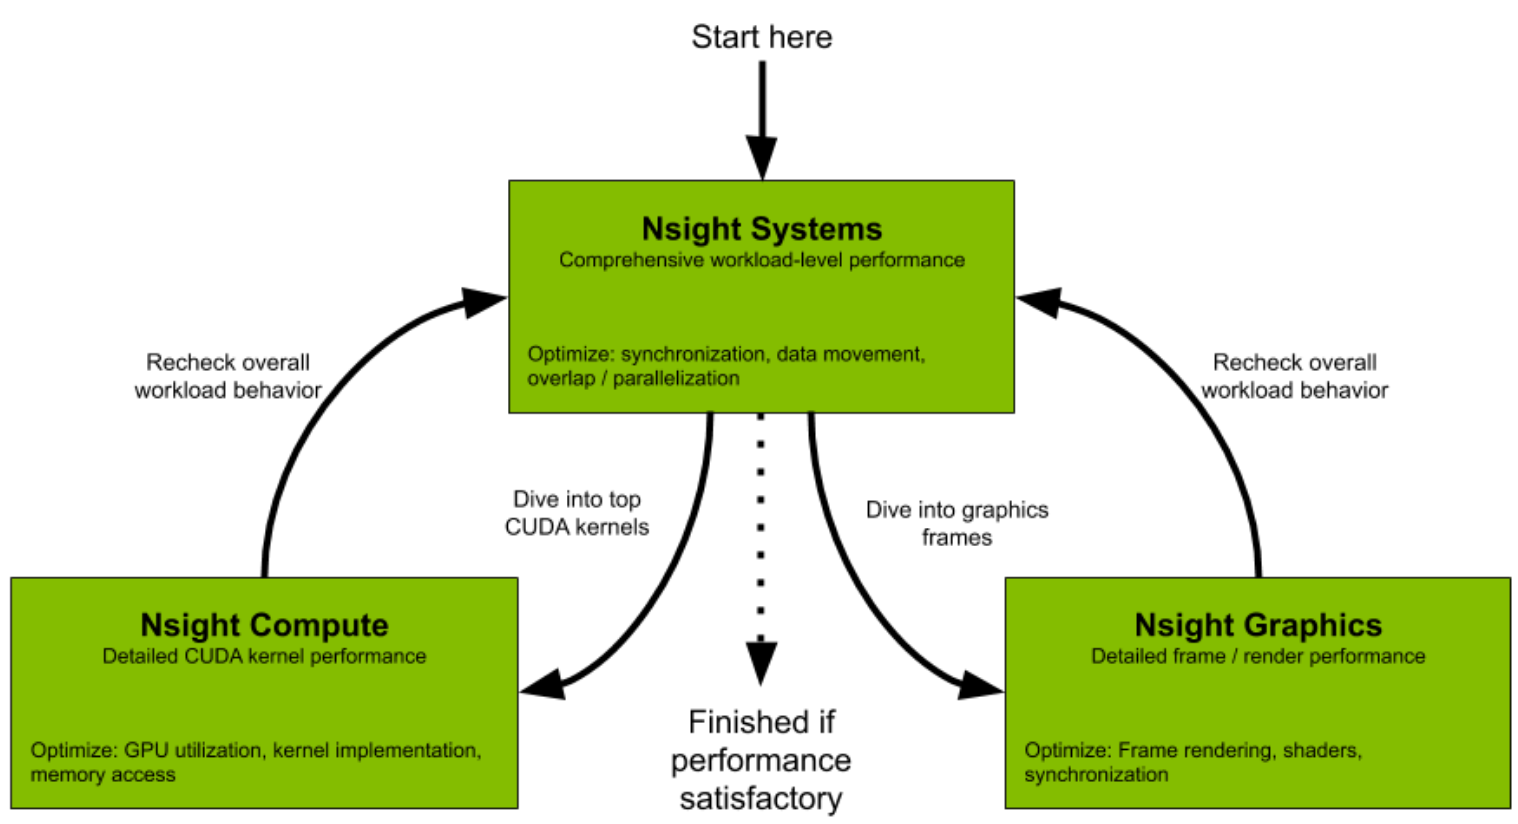

## NVIDIA Nsight Systems

The first NSight tool you should probably use to profile a GPU application, is NSight Systems. This tool gives an application-level overview, including a handy timeline, quickly visualizing times during execution where the GPU is underutilized and which operations are to blame for that.

The tool has two modes of operation:
- profile: run an application and profile at the end
- launch: launch an application for interactive profiling

There is also two ways of running the profiler:
- using the `nsys` binary on one end, and `nsys-ui` to visualize the result
- using `nsys-ui` to set-up and launch `nsys` automatically

First, verify that you can SSH to Piz Daint:

```
ssh -J class99@ela.cscs.ch class99@daint.cscs.ch
```

On the login node, activate the necessary modules and request an interactive session:

```
module load daint-gpu
module load Julia
srun -C gpu -n 1 -A class01 --time=00:30:00 --pty /bin/bash -l
```

Once our job has been allocated resources, launch Julia under `nsys`:

```
cd /scratch/snx3000/class99
nsight-systems-2021.4.1/bin/nsys launch julia
```

Note that it's better to run from somewhere in `/scratch`, because the home folder file system is slow and the profiling process mighth time out. Let's now try and benchmark the matrix multiplication from above.

In [13]:
using CUDA

A = CUDA.rand(Float32, 1024, 1024);
B = CUDA.rand(Float32, 1024, 1024);

# warmup
A * B

# profile execution
CUDA.@profile CUDA.@sync A * B;

┌ Warning: Calling CUDA.@profile only informs an external profiler to start.
│ The user is responsible for launching Julia under a CUDA profiler.
│ 
│ It is recommended to use Nsight Systems, which supports interactive profiling:
│ $ nsys launch julia
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:71


```
[ Info: Running under Nsight Systems, CUDA.@profile will automatically start the profiler

WARNING: CUDA tracing is required for cudaProfilerStart/Stop API support. Turning it on by default.
waiting for capture range to start the collection
Capture range started in the application
Capture range ended in the application
Processing events...
Saving temporary "/tmp/nsys-report-16b1-96f1-9095-b9f1.qdstrm" file to disk...

Creating final output files...
Processing [===============================================================100%]
Saved report file to "/tmp/nsys-report-16b1-96f1-9095-b9f1.nsys-rep"
Report file moved to "/scratch/snx3000/class99/report1.nsys-rep"

command ignored
[ Info: Profiling has finished, open the report listed above with `nsight-sys`
```

We now need to transfer this report file to our local system. You can do this using command-line tools like `scp`, or graphical tools like `WinSCP` or `FileZilla`. For those familiar with `sshfs`, it's even easier to mount the remote directory locally so that no transfers are required.

```
scp -J class99@ela.cscs.ch class99@daint.cscs.ch:/scratch/snx3000/class99/report1.nsys-rep .
```

To view this file, you need the NSight Systems viewer locally. Download this from [the NVIDIA website](https://developer.nvidia.com/nsight-systems), which requires an NVIDIA developer account to access. Once that's done, launch `nsys-ui` and open the report file.

Once you zoom in on the timeline, you should see the kernel invocation:

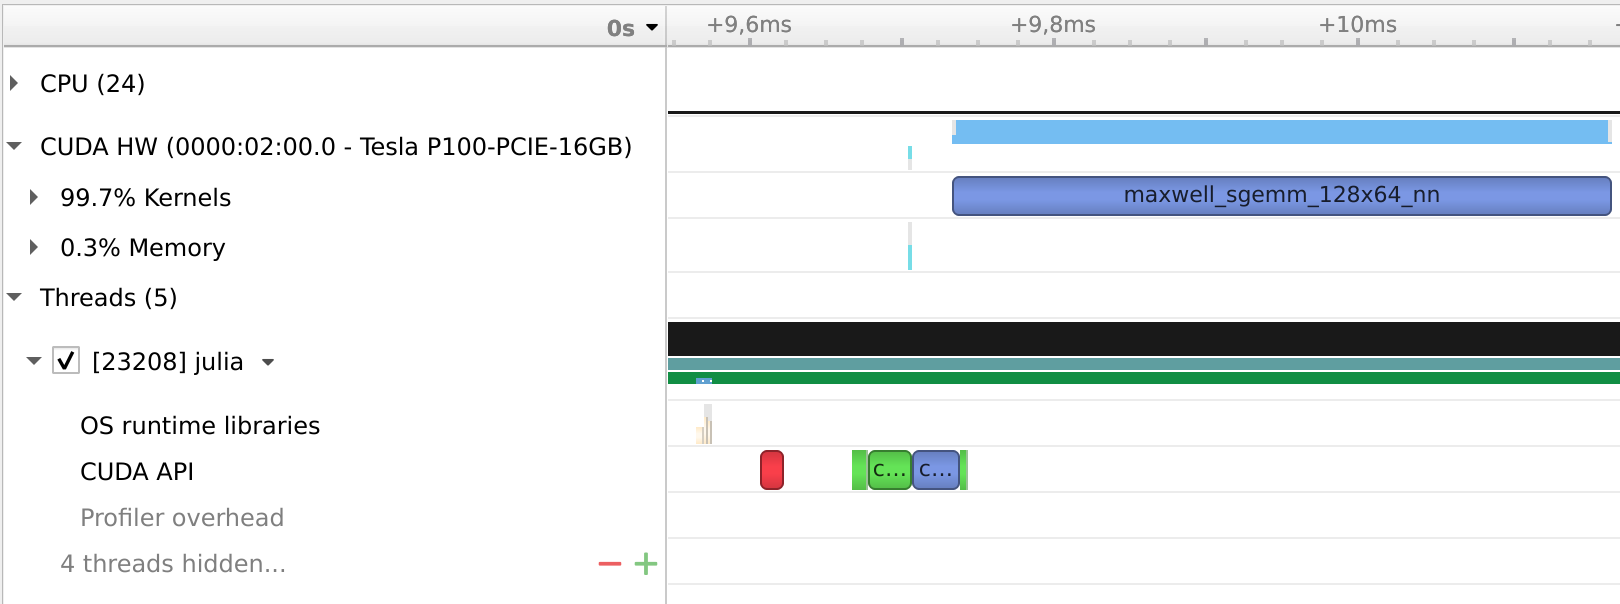

It's also possible to run Jupyter under NSight Systems, by adapting and adding the following kernel definition to `.local/share/jupyter/kernels`:

```
{
  "display_name": "Julia 1.7 (under NSight Systems)",
  "argv": [
    "/opt/nsight-systems-2021.4.1/bin/nsys",
    "launch",
    "/home/tim/.cache/jl/installs/bin/linux/x64/1.7/julia-1.7-latest-linux-x86_64/bin/julia",
    "-i",
    "--color=yes",
    "--project=@.",
    "/home/tim/Julia/depot/packages/IJulia/e8kqU/src/kernel.jl",
    "{connection_file}"
  ],
  "language": "julia",
  "env": {},
  "interrupt_mode": "signal"
}
```

I will do so for the remainder of this notebook.